# Определение аномалий с помощью DBScan

Процент аномалий, подсчитанный по переменной Class: 0.17 %.

## Загрузим данные
И импортируем необходимые библиотеки.

**DBScan не смог отработать на полном наборе данных: не хватило 64 Гб ОЗУ — производительность была низкая и закончились опыты переполнением ОЗУ.**

Поэтому уменьшим выборку до ≈ 10000 объектов со стратификацией по переменной Class.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

df_train = pd.read_csv(r'.\creditcard_train.csv')
df_test = pd.read_csv(r'.\creditcard_test.csv')


# Уменьшим размер наборов данных в n_reduce раз:
n_reduce = 20
df_train, _ = train_test_split(df_train, test_size=(1 - 1 / n_reduce), random_state=42, stratify=df_train['Class'])
df_test, _ = train_test_split(df_test, test_size=(1 - 1 / n_reduce), random_state=42, stratify=df_test['Class'])
print(df_train.shape)
print(df_test.shape)
#

X_train, y_train = df_train.drop('Class', axis=1), df_train['Class']
X_test, y_test = df_test.drop('Class', axis=1), df_test['Class']

(11392, 30)
(2848, 30)


## Подбор гиперпараметра eps

In [6]:
def calc_params_by_eps(scaled_data, outlier_percentage_threshold = 0.1, eps_start = 0.05, eps_step = 0.05): # ← гиперпараметры
    print('Перебор eps...')
    # для начала считаем все наблюдения аномальными
    outlier_percentage = 1.
    
    num_clusters = []
    anomaly_percentage = []
    
    # берем маленький эпсилон и начинаем увеличивать
    eps = eps_start
    eps_history = [eps]
    #i = 0
    while outlier_percentage > outlier_percentage_threshold: 
        model = DBSCAN(eps=eps).fit(scaled_data)
        labels = model.labels_
        num_clusters_item = len(np.unique(labels))-1

        labels = np.array([1 if label == -1 else 0 for label in labels])
        # считаем текущий процент "шума"
        outlier_percentage = sum(labels==1) / len(labels)
        eps += eps_step
        
        if outlier_percentage > 0:
            num_clusters.append(num_clusters_item)
            eps_history.append(eps)
            anomaly_percentage.append(outlier_percentage)
            
        #if i % 10 == 0 or outlier_percentage <= outlier_percentage_threshold:
        print('eps: {:.4f}; outlier_percentage: {:.4f} \t → {:.4f}'.format(eps, outlier_percentage, outlier_percentage_threshold))
        #i = i + 1
    print('Перебор eps завершён.')

    return (eps_history[:-1], num_clusters, anomaly_percentage)


def draw_clusters_eps_percengate_diagram(eps_history, num_clusters, anomaly_percentage):
    iterations = eps_history
    
    fig, ax1 = plt.subplots()
    
    color = 'tab:red'
    ax1.set_xlabel('epsilon')
    ax1.set_ylabel('number of clusters', color=color)
    ax1.plot(iterations, num_clusters, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()
    
    color = 'tab:blue'
    ax2.set_ylabel('anomaly percentage', color=color)
    ax2.plot(iterations, anomaly_percentage, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout()
    plt.show()


def get_optimal_eps(eps_history, num_clusters, anomaly_percentage, target_outlier_percentage):
    i_result = 0
    for i, perc in enumerate(anomaly_percentage):
        i_result = i
        if perc <= target_outlier_percentage:
            break
    return eps_history[i_result]
    

Перебор eps...
eps: 20.5000; outlier_percentage: 0.0019 	 → 0.0017
eps: 21.0000; outlier_percentage: 0.0017 	 → 0.0017
Перебор eps завершён.


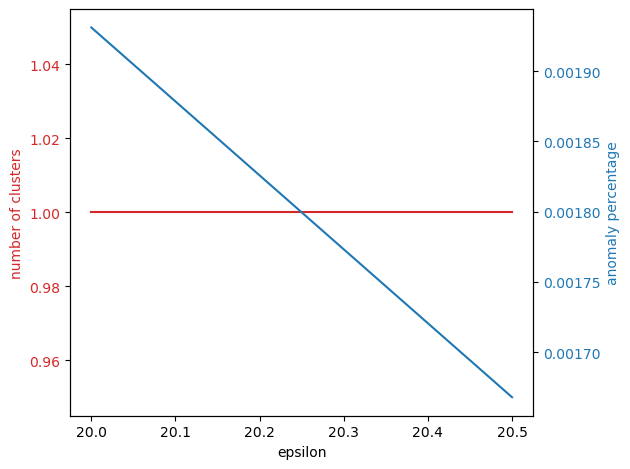

Для достижения детектирования доли аномалий: 0.0017
Подобран гиперпараметр eps: 20.50


In [7]:
target_outlier_percentage = 0.0017 # 0.17 %

eps_history, num_clusters, anomaly_percentage = calc_params_by_eps(X_train, target_outlier_percentage, 20, 0.5)
draw_clusters_eps_percengate_diagram(eps_history, num_clusters, anomaly_percentage)
optimal_eps = get_optimal_eps(eps_history, num_clusters, anomaly_percentage, target_outlier_percentage)
print('Для достижения детектирования доли аномалий:', target_outlier_percentage)
print('Подобран гиперпараметр eps: {:.2f}'.format(optimal_eps))

In [8]:
model = DBSCAN(optimal_eps)
model.fit(X_train)
density_outliers = np.array([1 if label == -1 else 0 for label in model.labels_])

In [9]:
# Вывод информации по аномальным транзакциям и выбросам
print('Количество выбросов в выборке: {}'.format(sum(density_outliers)))
print('Процент выбросов в выборке: {:.2%}'.format(sum(density_outliers)/len(X_train)))

Количество выбросов в выборке: 19
Процент выбросов в выборке: 0.17%


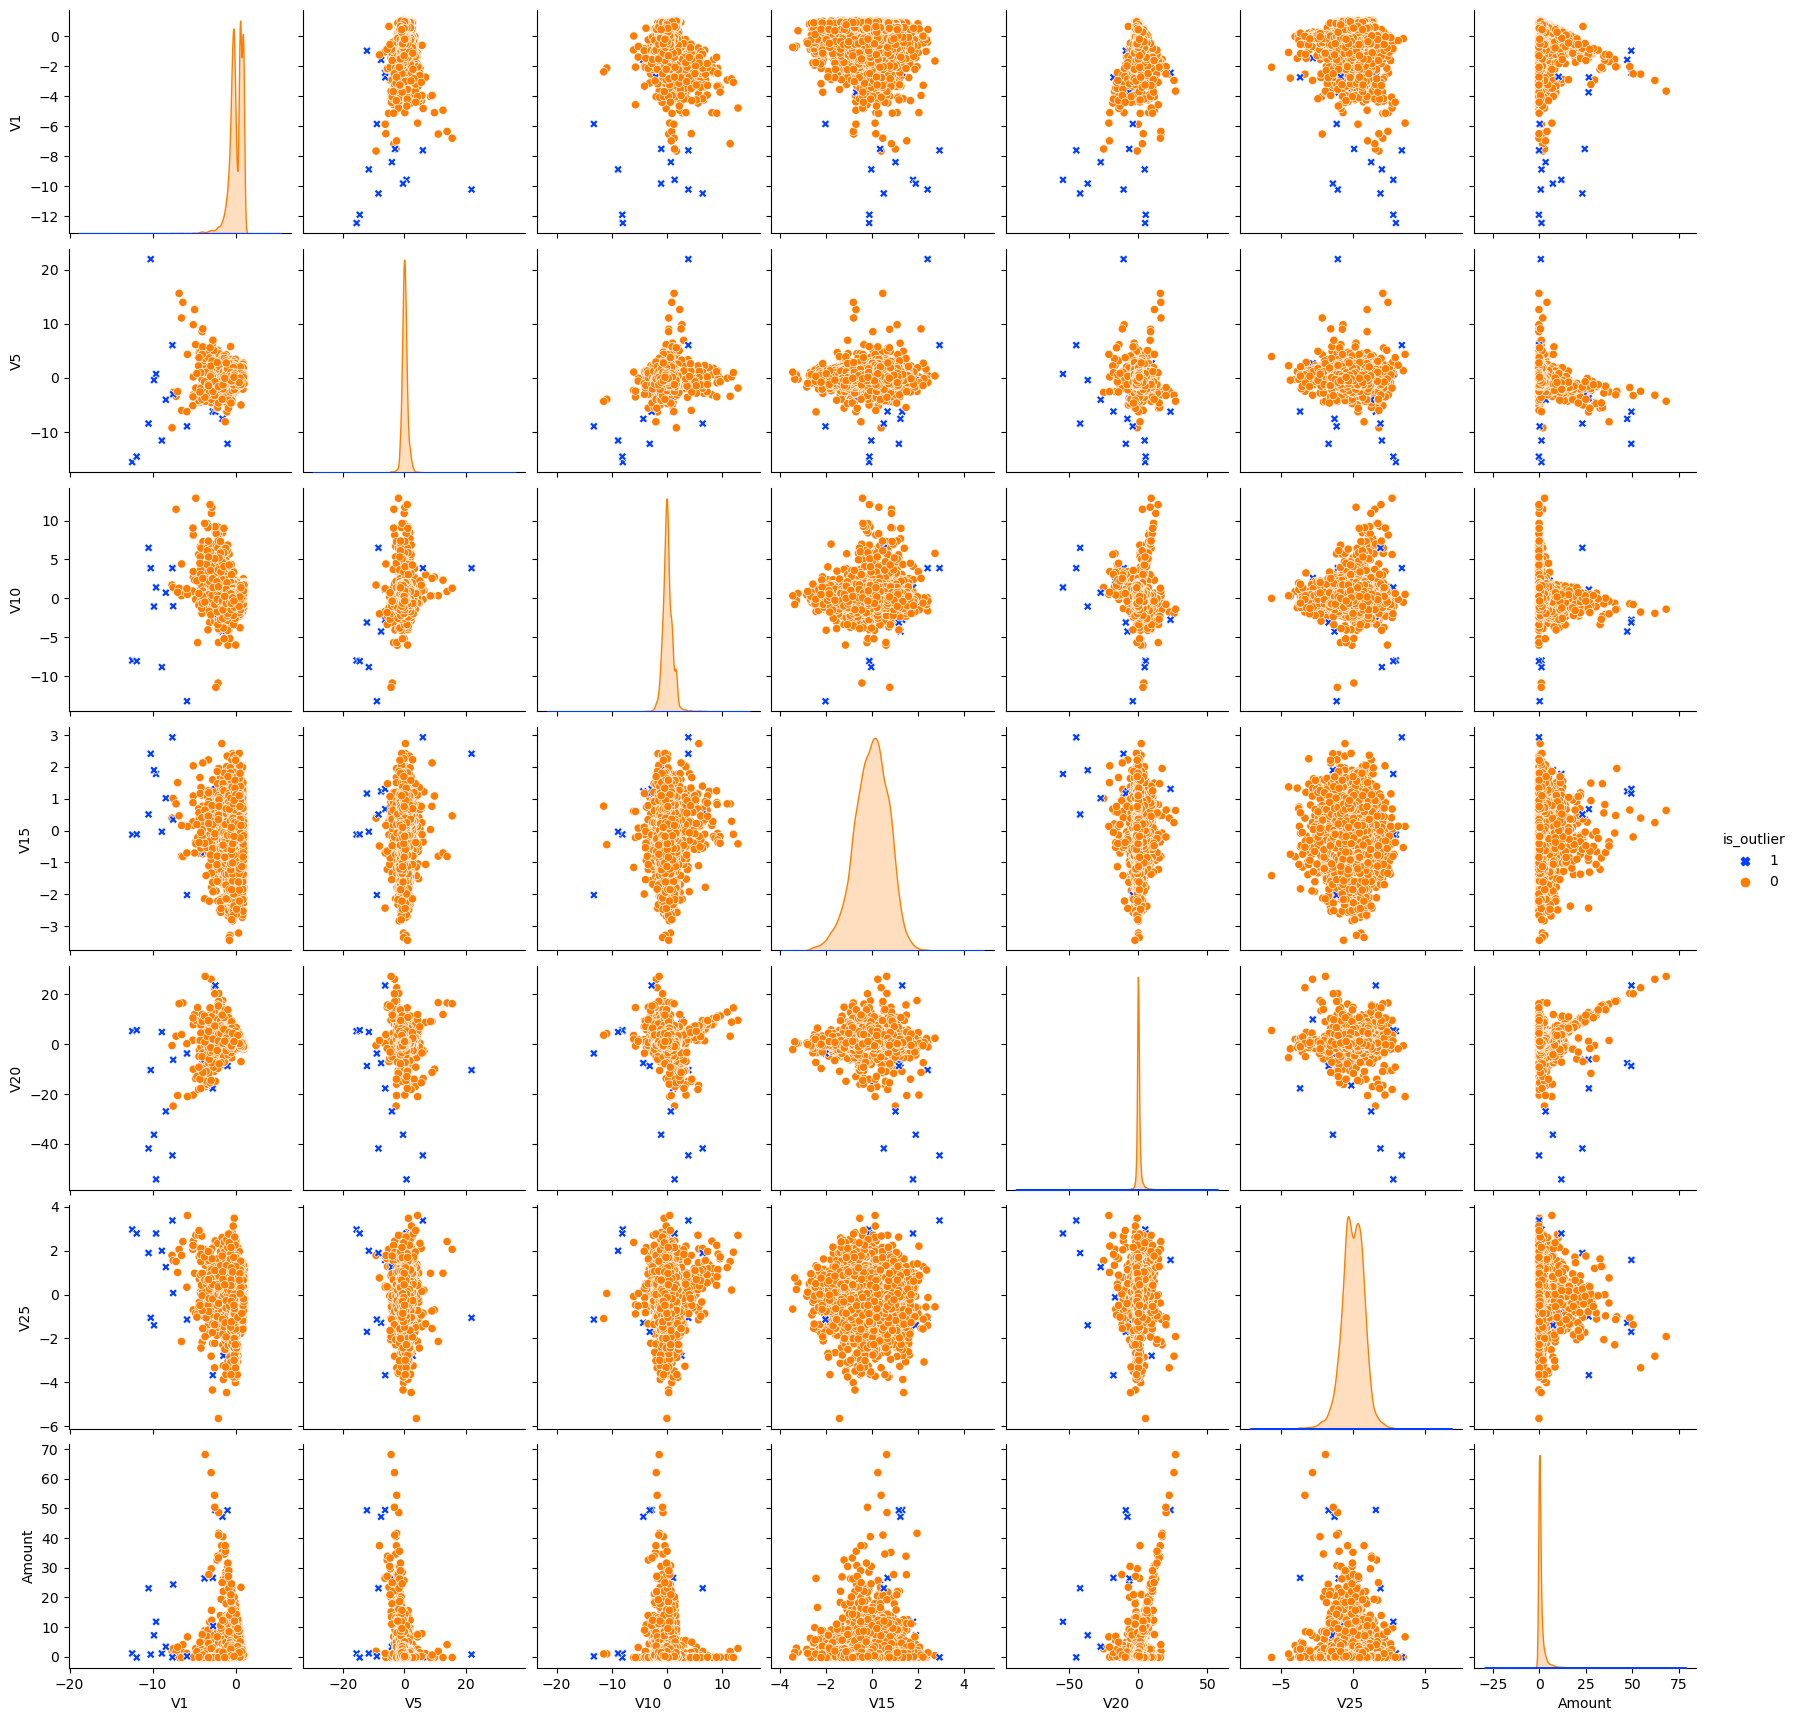

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_columns = ['V1', 'V5', 'V10', 'V15', 'V20', 'V25', 'Amount']

labeled_data = X_train.copy()
labeled_data['is_outlier'] = density_outliers

sns.pairplot(data=labeled_data, vars = selected_columns,
             hue='is_outlier', hue_order=[1, 0],
             markers=['o', 'X'],  palette='bright');

plt.savefig('DBScanPairplot.png')

## Протестируем на тестовой выборке

In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.fit(X_test)
y_pred = np.array([1 if label == -1 else 0 for label in model.labels_])

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = ['True 0', 'True 1'], columns = ['Predicted 0', 'Predicted 1'])
print('Confusion Matrix:\n')
print(df_cm)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2843
           1       0.00      0.00      0.00         5

    accuracy                           0.99      2848
   macro avg       0.50      0.50      0.50      2848
weighted avg       1.00      0.99      0.99      2848

Confusion Matrix:

        Predicted 0  Predicted 1
True 0         2826           17
True 1            5            0


## Визуализация с UMAP

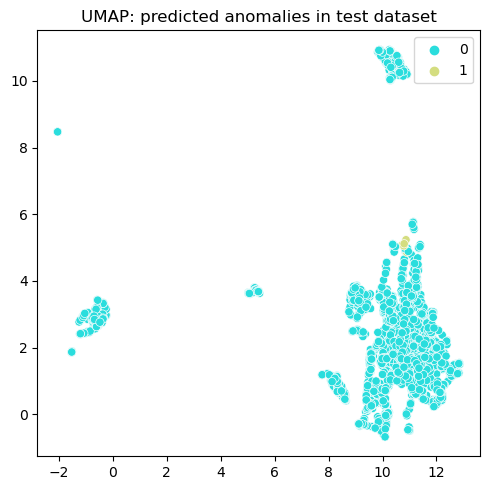

In [12]:
# !pip install umap-learn

import umap

# Manual settings:

n_components = 5 # Default 2
n_neighbors = 5 # Default 15
min_dist = 0.1 # Default 0.1

#

reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist) #, random_state=1) ← "Use no seed for parallelism"

# Processing with reduce dimensions
X_umap = reducer.fit_transform(X_test)

# Plot results
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=y_pred, palette='rainbow', ax=axs)
axs.set_title('UMAP: predicted anomalies in test dataset')
fig.get_figure().savefig('DBScanUMAPpredictedAnomaliesAtTest.png', dpi=120, bbox_inches='tight', pad_inches = 0.5)
plt.tight_layout()
plt.show()